In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from statistics import mode

# Question 1

In [2]:
## define edges color
cls_edges = 'blue'

## we will consider 3 types of nodes with the following colors and sizes:
cls = ['silver','red','black']
sz = [6,9,12]

In [3]:
## read edges and build weighted directed graph
D = pd.read_csv('connections.csv')
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
D.head() ## look at a few edges

,orig_airport,dest_airport,total_passengers
0,SFO,LAX,1442105
1,LAX,SFO,1438639
2,MCO,ATL,1436625
3,ATL,MCO,1424069
4,LAX,JFK,1277731


In [4]:
## read vertex attributes and add to graph
A = pd.read_csv('airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
A.head() ## first few rows in A

,airport,lon,lat,state,city
0,ABE,-75.440804,40.652100,PA,Allentown
1,ABI,-99.681900,32.411301,TX,Abilene
2,ABQ,-106.609001,35.040199,NM,Albuquerque
3,ABR,-98.421799,45.449100,SD,Aberdeen
4,ABY,-84.194504,31.535500,GA,Albany


In [5]:
#ig.plot(g, bbox=(0,0,300,300))

In [6]:
## Build smaller subgraph 'G' for New York
G_NY = g.subgraph([v for v in g.vs() if v['state'] == 'NY'])

print(G_NY.vcount(),'nodes and',G_NY.ecount(),'directed edges')

## drop isolated vertices (i.e. without in-state connections)
G_NY = G_NY.subgraph([v for v in G_NY.vs() if v.degree()>0])

print(G_NY.vcount(),'nodes and',G_NY.ecount(),'directed edges after removing isolated nodes')

## remove loops if any
G_NY = G_NY.simplify(multiple=False)
print(G_NY.vcount(),'nodes and',G_NY.ecount(),'directed edges after removing loops')


17 nodes and 53 directed edges
13 nodes and 53 directed edges after removing isolated nodes
13 nodes and 50 directed edges after removing loops


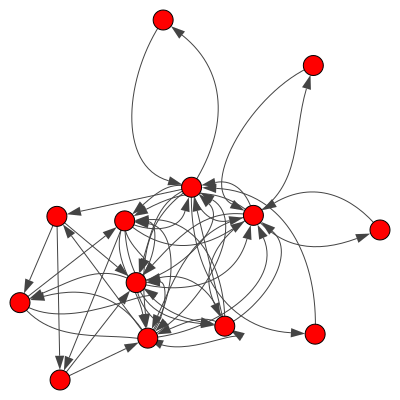

In [7]:
## plot using lat/lon as layout
#ly = ig.Layout(G.vs['layout']
#ly.mirror(1)
## y-axis goes top-down thus 9the inversion
ig.plot(G_NY, bbox=(0,0,400,400))

In [8]:
## compute normalized weights 
mw = np.max(G_NY.es['weight'])
G_NY.es()['normalized_weight'] = [w/mw for w in G_NY.es()['weight']]

## directed degree centrality
def degree_centrality(gr, weights=None):
    n = gr.vcount()
    if gr.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(gr.strength(mode='in',weights=weights),\
              gr.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in gr.strength(weights=weights)]
    return dc

In [9]:
## compute several centrality measures for the NY subgraph G
C = pd.DataFrame({'airport':G_NY.vs()['name'],\
                  'degree':degree_centrality(G_NY,weights='normalized_weight'),\
                  'pagerank':G_NY.pagerank(weights='weight'),'authority':G_NY.authority_score(weights='weight'),\
                  'hub':G_NY.hub_score(weights='weight'),'between':G_NY.betweenness(),\
                  'closeness':G_NY.closeness()})

## normalize betweenness
n = G_NY.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]

## sort w.r.t. degree centrality, look at top airports
Cs = C.sort_values(by='degree', ascending=False)
Cs.head()

,airport,degree,pagerank,authority,hub,between,closeness
0,JFK,0.173125,0.342720,1.000000,0.373760,0.647727,0.705882
2,BUF,0.101629,0.195702,0.261299,1.000000,0.167929,0.705882
4,ROC,0.054908,0.109433,0.141841,0.546989,0.000000,0.631579
5,SYR,0.044959,0.097118,0.113975,0.459400,0.243687,0.750000
1,LGA,0.040011,0.108312,0.213367,0.078989,0.286616,0.750000


# Question 2

In [136]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    new_tpl = []
    ## generate edges (tuples), drop collisions, until m edges are obtained.
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples

In [137]:
## power law graph
gamma = 2.5
n = 10000

## min and max degrees
delta = 1
Delta = np.sqrt(n)

## generate degrees
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

# deg = [int(np.round(w)) for w in W] ## to enforce integer weights, not an obligation
deg = W

## generate graph with Chung-Lu model
m = int(np.mean(deg)*n/2)
tpl = fastCL(deg,m)

G = ig.Graph.TupleList(tpl, weights=True)

## number of isolated nodes (no edges)
iso = n-G.vcount()
print('isolates:',iso)

isolates: 1871


In [139]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in',weights=weights),\
              g.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights)]
    return dc

In [169]:
## compute several centrality measures for the CA subgraph G
C = pd.DataFrame({'Degree':G.degree(),\
                  'degree_cent':degree_centrality(G),\
                  'pagerank':G.pagerank(),'authority':G.authority_score(),\
                  'hub':G.hub_score(),'between':G.betweenness(),\
                  'closeness':G.closeness()})

## normalize betweenness
n = G.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]

## sort w.r.t. degree centrality, look at top airports
Cs = C.sort_values(by='degree_cent', ascending=False)
Cs.head()

C_avg = C.groupby('Degree')[['degree_cent', 'pagerank', 'authority','hub','between','closeness']].mean()

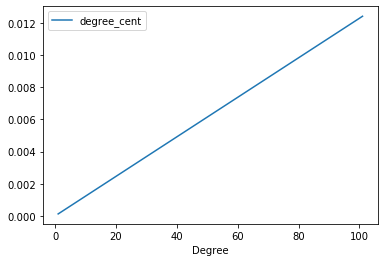

In [176]:
C_avg.plot(x='Degree', y='degree_cent')

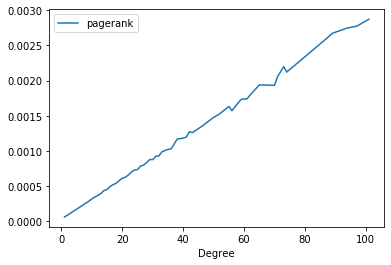

In [177]:
C_avg.plot(x='Degree', y='pagerank')

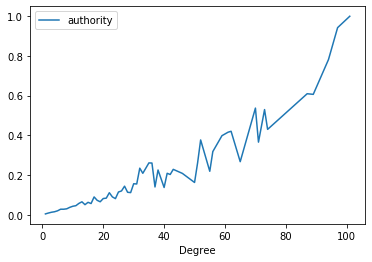

In [178]:
C_avg.plot(x='Degree', y='authority')

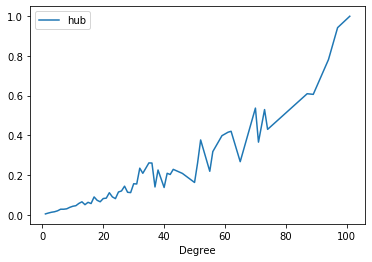

In [179]:
C_avg.plot(x='Degree', y='hub')

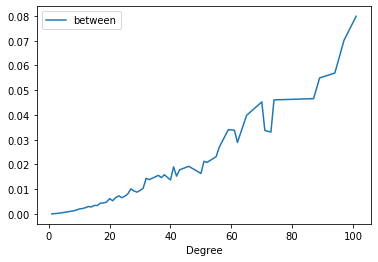

In [180]:
C_avg.plot(x='Degree', y='between')

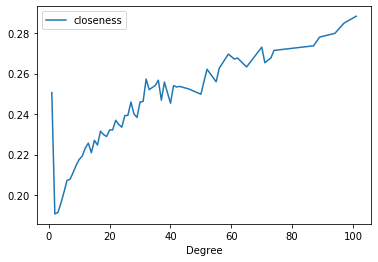

In [181]:
C_avg.plot(x='Degree', y='closeness')

# Typically, there is a positive correlation between all centrality measures and the degree of a node
# (trending up, minus some fluctuations are certain degrees)

# Question 3

In [11]:
D = pd.read_csv('connections.csv')
X = pd.read_csv('airports_loc.csv')

tuples = [tuple(x) for x in D.values]
ag = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ['weight'])
for s in ag.vs:
    s['lon'] = X.loc[X['airport'] == s['name'], 'lon'].iloc[0]
    s['lat'] = X.loc[X['airport'] == s['name'], 'lat'].iloc[0]
    s['state'] = X.loc[X['airport'] == s['name'], 'state'].iloc[0]
    s['city'] = X.loc[X['airport'] == s['name'], 'city'].iloc[0]
    

## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in',weights=weights),\
              g.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights)]
    return dc


In [12]:
# Degree
temp_ag = ag.copy()
temp_ag.delete_vertices(temp_ag.vs.find(name='DET'))
temp_ag.delete_vertices(temp_ag.vs.find(name='WVL'))
count_max = 0
while temp_ag.is_connected("weak"):
    mw = np.max(temp_ag.es['weight'])
    temp_ag.es()['normalized_weight'] = [w/mw for w in temp_ag.es()['weight']]    
    temp_ag.delete_vertices(np.argmax(degree_centrality(temp_ag, weights='normalized_weight')))
    count_max+= 1

temp_ag = ag.copy()
temp_ag.delete_vertices(temp_ag.vs.find(name='DET'))
temp_ag.delete_vertices(temp_ag.vs.find(name='WVL'))
count_min = 0
while temp_ag.is_connected("weak"):
    mw = np.max(temp_ag.es['weight'])
    temp_ag.es()['normalized_weight'] = [w/mw for w in temp_ag.es()['weight']]    
    temp_ag.delete_vertices(np.argmin(degree_centrality(temp_ag, weights='normalized_weight')))
    count_min+= 1
    

print('Deleting max degree centrality measure:', count_max)
print('Deeleting min degree centrality measure:', count_min)

Deleting max centrality measure: 2
Deeleting min centrality measure: 178


In [14]:
# Page Rank
temp_ag = ag.copy()
temp_ag.delete_vertices(temp_ag.vs.find(name='DET'))
temp_ag.delete_vertices(temp_ag.vs.find(name='WVL'))
count_max = 0
while temp_ag.is_connected("weak"):  
    temp_ag.delete_vertices(np.argmax(temp_ag.pagerank(weights='weight')))
    count_max+= 1

temp_ag = ag.copy()
temp_ag.delete_vertices(temp_ag.vs.find(name='DET'))
temp_ag.delete_vertices(temp_ag.vs.find(name='WVL'))
count_min = 0
while temp_ag.is_connected("weak"):  
    temp_ag.delete_vertices(np.argmin(temp_ag.pagerank(weights='weight')))
    count_min+= 1
    

print('Deleting max page rank centrality measure:', count_max)
print('Deeleting min page rank centrality measure:', count_min)

Deleting max page rank centrality measure: 2
Deeleting min page rank centrality measure: 39


In [15]:
# authority_score
temp_ag = ag.copy()
temp_ag.delete_vertices(temp_ag.vs.find(name='DET'))
temp_ag.delete_vertices(temp_ag.vs.find(name='WVL'))
count_max = 0
while temp_ag.is_connected("weak"):  
    temp_ag.delete_vertices(np.argmax(temp_ag.authority_score(weights='weight')))
    count_max+= 1

temp_ag = ag.copy()
temp_ag.delete_vertices(temp_ag.vs.find(name='DET'))
temp_ag.delete_vertices(temp_ag.vs.find(name='WVL'))
count_min = 0
while temp_ag.is_connected("weak"):  
    temp_ag.delete_vertices(np.argmin(temp_ag.authority_score(weights='weight')))
    count_min+= 1
    

print('Deleting max authority score centrality measure:', count_max)
print('Deeleting min authority score centrality measure:', count_min)

Deleting max authority score centrality measure: 2
Deeleting min authority score centrality measure: 5


In [16]:
# hub_score
temp_ag = ag.copy()
temp_ag.delete_vertices(temp_ag.vs.find(name='DET'))
temp_ag.delete_vertices(temp_ag.vs.find(name='WVL'))
count_max = 0
while temp_ag.is_connected("weak"):  
    temp_ag.delete_vertices(np.argmax(temp_ag.hub_score(weights='weight')))
    count_max+= 1

temp_ag = ag.copy()
temp_ag.delete_vertices(temp_ag.vs.find(name='DET'))
temp_ag.delete_vertices(temp_ag.vs.find(name='WVL'))
count_min = 0
while temp_ag.is_connected("weak"):  
    temp_ag.delete_vertices(np.argmin(temp_ag.hub_score(weights='weight')))
    count_min+= 1
    

print('Deleting max hub score centrality measure:', count_max)
print('Deeleting min hub score centrality measure:', count_min)

Deleting max hub score centrality measure: 2
Deeleting min hub score centrality measure: 8


In [17]:
# betweenness
temp_ag = ag.copy()
temp_ag.delete_vertices(temp_ag.vs.find(name='DET'))
temp_ag.delete_vertices(temp_ag.vs.find(name='WVL'))
count_max = 0
while temp_ag.is_connected("weak"):  
    temp_ag.delete_vertices(np.argmax(temp_ag.betweenness()))
    count_max+= 1

temp_ag = ag.copy()
temp_ag.delete_vertices(temp_ag.vs.find(name='DET'))
temp_ag.delete_vertices(temp_ag.vs.find(name='WVL'))
count_min = 0
while temp_ag.is_connected("weak"):  
    temp_ag.delete_vertices(np.argmin(temp_ag.betweenness()))
    count_min+= 1
    

print('Deleting max betweeness centrality measure:', count_max)
print('Deeleting min betweeness centrality measure:', count_min)

Deleting max betweeness centrality measure: 4
Deeleting min betweeness centrality measure: 64


In [19]:
# closeness
temp_ag = ag.copy()
temp_ag.delete_vertices(temp_ag.vs.find(name='DET'))
temp_ag.delete_vertices(temp_ag.vs.find(name='WVL'))
count_max = 0
while temp_ag.is_connected("weak"):  
    temp_ag.delete_vertices(np.argmax(temp_ag.closeness()))
    count_max+= 1

temp_ag = ag.copy()
temp_ag.delete_vertices(temp_ag.vs.find(name='DET'))
temp_ag.delete_vertices(temp_ag.vs.find(name='WVL'))
count_min = 0
while temp_ag.is_connected("weak"):  
    temp_ag.delete_vertices(np.argmin(temp_ag.closeness()))
    count_min+= 1
    

print('Deleting max closeness centrality measure:', count_max)
print('Deleting min closeness centrality measure:', count_min)

Deleting max closeness centrality measure: 1
Deleting min closeness centrality measure: 462


# Question 5

In [20]:
#Generating the mapping vector for contracting the vertices
counter = 0
mvector = [0] * 464
states = np.unique(g.vs()['state'])
for i in range(51):
    for j in range(464):
        if(g.vs()[j]['state']==states[i]):
            mvector[j] = counter
    mvector
    counter+=1
#print(mvector)

In [21]:
#Collapsing the original graph to a state-to-state graph
g.contract_vertices(mvector, combine_attrs=dict(state='first', size='first'))

In [22]:
#removing self loops
g.simplify(multiple=False)

In [23]:
#adding the edge weights of airports to form the new edge weight of a state
g.simplify(combine_edges=dict(weight=sum))

In [24]:
print('number of loop edges:',sum(g.is_loop()))
print('number of multiple edges:',sum(g.is_multiple()))

number of loop edges: 0
number of multiple edges: 0


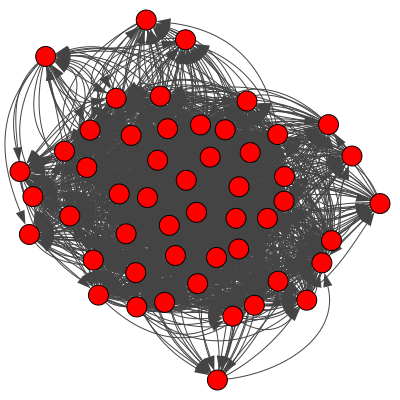

In [25]:
#Plotting the state-to-state graph
ig.plot(g, bbox=(0,0,400,400))

5a)Is G weakly connected? Strongly connected?

In [26]:
## count the number of nodes in the giant component (weak connectivity)
print(g.clusters(mode='WEAK').giant().vcount(),'out of',g.vcount(),'are in giant (weak) component')
print(g.clusters(mode='STRONG').giant().vcount(),'out of',g.vcount(),'are in giant (strong) component')

51 out of 51 are in giant (weak) component
51 out of 51 are in giant (strong) component


C:\Users\Brandon\AppData\Local\Temp/ipykernel_26648/230913530.py:2: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  print(g.clusters(mode='WEAK').giant().vcount(),'out of',g.vcount(),'are in giant (weak) component')
C:\Users\Brandon\AppData\Local\Temp/ipykernel_26648/230913530.py:3: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  print(g.clusters(mode='STRONG').giant().vcount(),'out of',g.vcount(),'are in giant (strong) component')


# The graph is strongly connected with 51 nodes in the strong component

# The graph is weakly connected with 51 nodes in the weak component


5b)Which state has the most incoming passengers? The most de-
parting passengers?

In [27]:
# Finding the edge with maximum weight
max_weight = max(g.es()['weight'])
print('The maximum number of passengers travelling between any two states is', max(g.es()['weight']))

The maximum number of passengers travelling between any two states is 6584065


In [28]:
# Finding the location of the edge with maximum weight
index = 0
for i in range(len(g.es())):
    if(g.es()[i]['weight']==max_weight):
        index = i
print('The edge with maximum passengers is located at', index)

The edge with maximum passengers is located at 313


In [29]:
# Finding the corresponding vertices of the edge with maximum weight
Target_State_idx = g.es[index].target
Target_State = g.vs()[Target_State_idx]['state']
print('The state with most incoming passengers is', Target_State)
Source_State_idx = g.es[index].source
Source_State = g.vs()[Source_State_idx]['state']
print('The state with most departing passengers is', Source_State)

The state with most incoming passengers is GA
The state with most departing passengers is FL


In [30]:
print('States', Target_State, 'and', Source_State, 'have the most passengers travelling from', Source_State, 'to',  Target_State)

States GA and FL have the most passengers travelling from FL to GA


In [31]:
## compute normalized weights 
mw = np.max(g.es['weight'])
g.es()['normalized_weight'] = [w/mw for w in g.es()['weight']]

In [32]:
## compute several centrality measures for the state-to-state graph
C = pd.DataFrame({'state':g.vs()['state'],\
                  'degree':degree_centrality(g,weights='normalized_weight'),\
                  'pagerank':g.pagerank(weights='weight'),'authority':g.authority_score(weights='weight'),\
                  'hub':g.hub_score(weights='weight'),'between':g.betweenness(),\
                  'closeness':g.closeness()})

## normalize betweenness
n = g.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]

## sort w.r.t. degree centrality
Cs = C.sort_values(by='degree', ascending=False)
Cs.head()

,state,degree,pagerank,authority,hub,between,closeness
4,CA,0.135169,0.075945,0.969771,0.971337,0.021798,0.943396
9,FL,0.131269,0.073844,1.000000,1.000000,0.025327,0.943396
43,TX,0.130073,0.077688,0.925013,0.925349,0.028044,0.980392
10,GA,0.107684,0.064350,0.829178,0.827263,0.024180,0.961538
14,IL,0.104197,0.063423,0.743696,0.742924,0.037366,1.000000


# The top 5 states with highest degree centrality are CA, FL, TX, GA, and IL

In [33]:
## sort w.r.t. betweenness centrality
Cs = C.sort_values(by='between', ascending=False)
Cs.head()

,state,degree,pagerank,authority,hub,between,closeness
14,IL,0.104197,0.063423,0.743696,0.742924,0.037366,1.000000
35,OH,0.047638,0.030171,0.362870,0.363212,0.030574,0.980392
43,TX,0.130073,0.077688,0.925013,0.925349,0.028044,0.980392
23,MN,0.042512,0.031069,0.284188,0.284230,0.026444,0.961538
7,DC,0.048661,0.030078,0.418859,0.418278,0.026146,0.980392


# The top 5 states with highest betweennesss centrality are IL, OH, TX, MN, and DC